<a href="https://colab.research.google.com/github/scpepper69/ml-learning-materials/blob/master/TensorFlow_Keras_LSTM_01_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/intel-analytics/analytics-zoo/master/pyzoo/zoo/util/tf_graph_util.py

--2019-09-12 11:26:32--  https://raw.githubusercontent.com/intel-analytics/analytics-zoo/master/pyzoo/zoo/util/tf_graph_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19584 (19K) [text/plain]
Saving to: ‘tf_graph_util.py’

tf_graph_util.py    100%[===================>]  19.12K  --.-KB/s    in 0.004s  

2019-09-12 11:26:38 (4.93 MB/s) - ‘tf_graph_util.py’ saved [19584/19584]



In [0]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
import tensorflow as tf
from tensorflow.python.framework import graph_io
import tf_graph_util as graph_util
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


--2019-09-12 11:36:44--  https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/stock_auto_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24625 (24K) [text/plain]
Saving to: ‘stock_auto_data.csv.4’

stock_auto_data.csv 100%[===================>]  24.05K  --.-KB/s    in 0.003s  

2019-09-12 11:36:44 (6.86 MB/s) - ‘stock_auto_data.csv.4’ saved [24625/24625]

     7201  7203    7261    7267    7270
0  1201.5  7097  1975.5  3571.0  4991.0
1  1199.5  7049  1943.0  3569.0  4966.0
2  1173.0  6930  1881.5  3501.0  4934.0
3  1170.5  6861  1855.0  3462.0  4858.0
4  1172.0  6912  1860.5  3471.0  4874.0


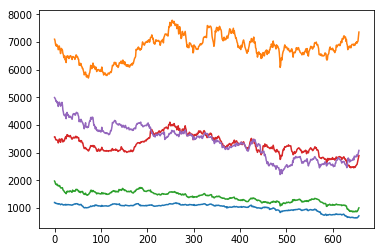

In [7]:
# 予測対象のサンプルデータを取得
!wget https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/stock_auto_data.csv

dataframe = pandas.read_csv('./stock_auto_data.csv', usecols=[1,2,3,4,5], engine='python', skipfooter=0)
print(dataframe.head())
plt.plot(dataframe)
plt.show()

In [8]:
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) -31)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

627 31


In [11]:
# convert an array of values into a dataset matrix
# if you give look_back 3, a part of the array will be like this: Jan, Feb, Mar
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    #for i in range(len(dataset)-look_back-1):
    for i in range(len(dataset)-look_back):
        xset = []
        yset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
            b = dataset[i + look_back, j] #add
            yset.append(b) #add
        #dataY.append(dataset[i + look_back, 0])
        dataX.append(xset)
        dataY.append(yset) #add
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX.shape)
print(testX[0])
print(testY)

(1, 5, 30)
[[1.35105968e-01 1.48580551e-01 1.18397355e-01 1.15882158e-01
  8.40818882e-02 3.05426121e-02 7.04275370e-02 6.10852242e-02
  4.86884117e-02 5.53359985e-02 2.87460089e-02 3.16205025e-02
  1.83254480e-02 2.49730349e-02 3.32375765e-02 4.38375473e-02
  2.55119801e-02 3.34171057e-02 2.51526833e-02 7.00676441e-03
  4.31180000e-03 6.28817081e-03 5.38945198e-04 2.06612349e-02
  5.03051281e-03 2.04814672e-02 0.00000000e+00 2.29967833e-02
  5.22817373e-02 9.45023298e-02]
 [6.96214676e-01 7.11547613e-01 6.36799335e-01 6.69381857e-01
  5.91279507e-01 5.70675611e-01 4.91135597e-01 5.25155783e-01
  5.34259796e-01 5.47197104e-01 5.24676561e-01 5.54863453e-01
  5.27072430e-01 5.24676561e-01 5.64446688e-01 5.81696272e-01
  5.81696272e-01 5.80258846e-01 5.85050344e-01 5.62530041e-01
  5.86487770e-01 5.72113037e-01 5.72592258e-01 6.06133223e-01
  6.02299929e-01 6.27695322e-01 6.04216576e-01 6.25299454e-01
  6.39674187e-01 7.12985277e-01]
 [2.06884146e-01 2.11827099e-01 1.94302142e-01 1.884605

In [0]:
# reshape input to be [samples, time steps(number of variables), features] *convert time series into column
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(400, input_shape=(trainX.shape[1], look_back))) #shape：variables,loopback time
model.add(BatchNormalization())
model.add(Dense(trainX.shape[1])) # dimension count
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(trainX, trainY, epochs=320, batch_size=16, verbose=2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 400)               689600    
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
dense (Dense)                (None, 5)                 2005      
Total params: 693,205
Trainable params: 692,405
Non-trainable params: 800
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/320
597/597 - 6s - loss: 0.2320
Epoch 2/320
597/597 - 0s - loss: 0.0200
Epoch 3/320
597/597 - 0s - loss: 0.0094
Epoch 4/320
597/597 - 0s - loss: 0.0062
Epoch 

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
pad_col = numpy.zeros(dataset.shape[1]-1)

# invert predictions
#def pad_array(val):
#    return numpy.array([numpy.insert(pad_col, 0, x) for x in val])

In [0]:
# invert predictions
#def pad_array(val):
#    return numpy.array([numpy.insert(pad_col, 0, x) for x in val])

#trainPredict = scaler.inverse_transform(pad_array(trainPredict))
#trainY = scaler.inverse_transform(pad_array(trainY))
#testPredict = scaler.inverse_transform(pad_array(testPredict))
#testY = scaler.inverse_transform(pad_array(testY))

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [16]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 29.34 RMSE
Test Score: 25.92 RMSE


[718.4001]
[744.3211]


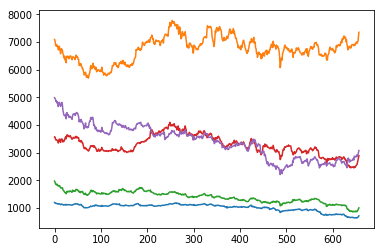

In [17]:
print(testY[:,0])
print(testPredict[:,0])
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

plt.close()

In [18]:
K.set_learning_phase(0)
ksess = K.get_session()
#print(ksess)

#K.set_learning_phase(0)
graph = ksess.graph
kgraph = graph.as_graph_def()
print(kgraph)

output_names = [node.op.name for node in model.outputs]
freeze_var_names = list(set(v.op.name for v in tf.global_variables()))

node {
  name: "lstm_input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 5
        }
        dim {
          size: 30
        }
      }
    }
  }
}
node {
  name: "lstm/kernel/Initializer/random_uniform/shape"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@lstm/kernel"
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 2
          }
        }
        tensor_content: "\036\000\000\000@\006\000\000"
      }
    }
  }
}
node {
  name: "lstm/kernel/Initializer/random_uniform/min"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@lstm/kernel"
      }
    }
  }
  attr {
    key: "dtype"
    

In [19]:
# fix batch norm nodes
for node in kgraph.node:
    if node.op == 'RefSwitch':
        node.op = 'Switch'
        for index in range(len(node.input)):
            if 'moving_' in node.input[index] and "Switch" not in node.input[index]:
                node.input[index] = node.input[index] + '/read'
    elif node.op == 'AssignSub':
        node.op = 'Sub'
        if 'use_locking' in node.attr: del node.attr['use_locking']
    elif node.op == 'AssignAdd':
        node.op = 'Add'
        if 'use_locking' in node.attr: del node.attr['use_locking']

# convert variables in the model graph to constants
constant_graph = graph_util.convert_variables_to_constants(ksess, kgraph, output_names)
#constant_graph = mod_graph_util.convert_variables_to_constants(ksess, kgraph, output_names)

output_dir = "./"
output_graph_name = "stock_auto.pb"
output_text_name = "stock_auto.txt"
graph_io.write_graph(constant_graph, output_dir, output_graph_name, as_text=False)
graph_io.write_graph(constant_graph, output_dir, output_text_name, as_text=True)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 9 variables.
INFO:tensorflow:Converted 9 variables to const ops.


'./stock_auto.txt'